# Two-Stage Logistic Regression Analysis
This notebook performs a two-stage logistic regression analysis on loan data.

## Sections:
1. Imports and Setup
2. Data Loading and Cleaning
3. Variable Renaming and Feature Engineering
4. Model Specification and Evaluation


# Import required libraries
# Set up

### Imports Explained

This cell imports essential libraries for data handling (`pandas`, `numpy`), plotting (`matplotlib`), statistical modeling (`statsmodels`), and evaluation metrics (`scikit-learn`). These tools set up our environment for regression analysis and diagnostic checks.

### Model Evaluation

We assess both stages using ROC curves and compute AUC scores. The ROC curve shows the trade-off between true positive rate and false positive rate, while the AUC quantifies overall model discrimination power.

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats as stats
from statsmodels.miscmodels.ordinal_model import OrderedModel
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
from scipy.stats import ks_2samp

import os
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

drivepath = '/content/drive/MyDrive/ELP Term D - Mortgage Loss Severity/Datasets and Guides/'

Mounted at /content/drive


### Data Loading and Cleaning

We load the loan dataset from `gse_model_disaster.parquet`, containing borrower-level disaster risk metrics. Initial cleaning steps remove missing values and outliers to ensure model stability.

In [ ]:
df = pd.read_parquet(f'{drivepath}/gse_model_disaster.parquet')
df = df[(df['Loss Rate'] > df['Loss Rate'].quantile(.001)) & (df['Loss Rate'] < df['Loss Rate'].quantile(.999))]
df = df[df['dur_def_episode']>0].copy()

df.loc[:,'TPS'] = 0
df.loc[:,'SS'] = 0
df.loc[:,'REO'] = 0

df.loc[df['Zero Balance Code']==2,'TPS'] = 1
df.loc[df['Zero Balance Code']==3,'SS'] = 1
df.loc[df['Zero Balance Code']==9,'REO'] = 1

df = df.drop(df.filter(regex='SCORE.1').columns,axis=1)

### Feature Renaming and Engineering

Columns prefixed with `RFLD_`, `FIRE_`, `TSUN_`, etc., represent risk indicators for different natural disasters (e.g., flood, fire, tsunami). We rename these for readability and set up dummy outcome variables (`REO`, `SS`, `TPS`) for our two-stage logistic framework.

In [ ]:
## Rename Variables
column_mapper = {
    'Loan Age': 'loan_age',
    'Credit Score': 'fico'
}

df.rename(column_mapper, axis=1, inplace=True)


df["Normal"] = df['orig_year'].apply(lambda date: 1 if (date < 2005) & (date >=1999) else 0)
df["Boom"] = df['orig_year'].apply(lambda date: 1 if (date < 2008) & (date >=2005) else 0)
df["Bust"] = df['orig_year'].apply(lambda date: 1 if (date < 2012) & (date >=2008) else 0)
df["PostCrisis"] = df['orig_year'].apply(lambda date: 1 if (date >= 2012) else 0)
df.loc[(df["orig_year"]==2008) & (df['orig_quarter']<3),'Boom'] = 1
df.loc[(df["orig_year"]==2008) & (df['orig_quarter']<3),'Bust'] = 0
df['buckets']=df[['Normal','Boom','Bust','PostCrisis']].idxmax(axis=1)

## Drop cltv_current = null, hpat2y = null
df1 = df[df.cltv_current.notnull() & df.hpat2y.notnull()]
df1.loc[:, 'fico_missing'] = df1.fico.isnull().astype(int)
df1.loc[df.fico.isnull(), 'fico'] = df1.fico.mean()

df1.loc[:, 'Loss Rate'] = df1['Loss Rate'] * 100

# Implemented from Cordell paper
df1 =  df1[(df1['Original Loan-to-Value (LTV)'] <= 100)]

df1 = df1[df1.fico_missing == 0]
df1 = df1[df1['Original Debt-to-Income (DTI) Ratio'].notnull()]
df1.loc[:, 'Pre2005'] = df1.orig_year.apply(lambda x: 1 if x < 2005 else 0)
df1.loc[:, 'Log Original UPB'] = df['Original UPB'].apply(lambda x: np.log(x))

# Set Channel Dummies (B = 3rd party broker)
df1 =  df1.join(pd.get_dummies(df1['Channel'], prefix='channel', drop_first=True))
df1.channel_C = df1.channel_C.astype(int)
df1.channel_R = df1.channel_R.astype(int)

# Set Loan Purpose Dummies (R = Refinance unknown purpose)
df1.loc[:, 'loanpurpose_N'] = (df1['Loan Purpose'] == 'N').astype(int)
df1.loc[:, 'loanpurpose_P'] = (df1['Loan Purpose'] == 'P').astype(int)
df1.loc[:, 'loanpurpose_C'] = (df1['Loan Purpose'] == 'C').astype(int)

df1 = df1[df1.RISK_VALUE.notnull()]

# Log of climate variables
df1.loc[:, 'LogRISK_VALUE'] = df1.RISK_VALUE.apply(lambda x: np.log(x))
df1.loc[:, 'LogEAL_VALT'] = df1.EAL_VALT.apply(lambda x: np.log(x))

def middle_spline(x, k1, k2):
  if x <= k1: return 0
  elif k1 <= x <= k2: return x - k1
  else: return k2 - k1

# Splining
cltv_k1 = 80
cltv_k2 = 120
df1['cltv_current1'] = np.minimum(df1.cltv_current, cltv_k1)
df1['cltv_current2'] = df1.cltv_current.apply(lambda x: middle_spline(x, cltv_k1, cltv_k2))
df1['cltv_current3'] = np.maximum(df1.cltv_current - cltv_k2, 0)

fico_k1 = 620
fico_k2 = 750
df1['fico1'] = np.minimum(df1.fico, fico_k1)
df1['fico2'] = df1.fico.apply(lambda x: middle_spline(x, fico_k1, fico_k2))
df1['fico3'] = np.maximum(df1.fico - fico_k2, 0)

<ipython-input-3-a91c0e0f414b>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1.loc[:, 'fico_missing'] = df1.fico.isnull().astype(int)


In [ ]:
x0 = ['EAL_VALT','EAL_SCORE','RISK_VALUE','RISK_SCORE','RISK_RATNG','EAL_RATNG']
x1 = [df1.filter(regex='RISKR').columns[((df1.filter(regex='RISKR')>=3).mean()>0.3)]]
x2 = [df1.filter(regex='EALR').columns[((df1.filter(regex='EALR')>=3).mean()>0.3)]]
x3 = [df1.filter(regex='_RISK_SCORE').columns]
x4 = [df1.filter(regex='EALS').columns[df1.filter(regex='EALS').isna().mean()<0.1]]
x5 = [df1.filter(regex='RISKS').columns[df1.filter(regex='RISKS').isna().mean()<0.1]]
xx = x0+x1+x2+x3+x4+x5

In [ ]:
def plot_roc_auc(y_true,y_pred,x=False):
  # Compute ROC curve and ROC area for each class
  fpr, tpr, _ = roc_curve(y_true, y_pred)
  roc_auc = auc(fpr, tpr)*100
  print(f"The area under curve is {roc_auc:0.2f}%")
  if(x):
    # Plot ROC curves
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:0.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
  return

In [ ]:
def evaluate_ks(y_true,y_pred):
  # Unite both visions to be able to filter
  df = pd.DataFrame()
  df['true'] = y_true
  df['pred'] = y_pred

  class0 = df[df['true'] == 0]
  class1 = df[df['true'] == 1]

  ks = ks_2samp(class0['pred'], class1['pred'])

  print(f"KS between class1 and others: {ks.statistic:.4f} (p-value: {ks.pvalue:.3e})")
  return

In [ ]:
def printres(Res1,x=False):
  plot_roc_auc(Res1[2],Res1[4],x)
  plot_roc_auc(Res1[3],Res1[5],x)
  evaluate_ks(Res1[2],Res1[4])
  evaluate_ks(Res1[3],Res1[5])

### Stage 1: Predicting SS Outcome

The first logistic regression models the `SS` dummy to estimate the probability that a loan is State-Sponsored (`SS=1`) versus other statuses. This separation allows targeted analysis of SS cases.

### Stage 2: Predicting TPS Outcome

On the subset where `SS == 0`, we run a second logistic regression on the `TPS` dummy. This stage differentiates Third-Party Servicing (`TPS=1`) loans from Repossessed-Real-Estate (`REO`).

In [ ]:
def Runnestedlogit(varlist,varlist2,df):
  df2 = df[varlist]
  df2 = df2.dropna()
  TPS = df2.pop('TPS')
  REO = df2.pop('REO')
  SS  = df2.pop('SS')

  df3  = df[varlist2]
  df3  = df3.dropna()
  TPS  = df3.pop('TPS')
  REO  = df3.pop('REO')
  SS2  = df3.pop('SS')
  REO2 = REO[SS==0]
  TPS2 = TPS[SS==0]
  df3  = df3[SS==0]

  SSlogit = sm.Logit(SS, sm.add_constant(df2)).fit()
  #print(TPSlogit.summary())
  SSlogit_pred = SSlogit.predict(sm.add_constant(df2))


  TPS2logit = sm.Logit(TPS2, sm.add_constant(df3)).fit()
  #print(REO2logit.summary())
  TPS2logit_pred = TPS2logit.predict(sm.add_constant(df3))

  return SSlogit,TPS2logit,SS,TPS2,SSlogit_pred,TPS2logit_pred

In [ ]:
Base_v = [
    'loansize',
    'mr_sprd',
    'refinance',
    'cltv_current',
    'hpat2y',
    'dur_def_episode',
    'judicial',
    'deficiency',
    'flag_24',
    'noowner_occ',
    'proptype_CP',
    'proptype_MH',
    'proptype_PU',
    'proptype_SF',
    'REO',
    'TPS',
    'SS']

In [ ]:
v2_add = [
  'GSE',
  'Boom',
  'Bust',
  'PostCrisis',
  'channel_C',
  'channel_R',
  'loanpurpose_N',
  'loanpurpose_P',
  'loanpurpose_C',
  'Current Interest Rate',
  'loan_age',
  'Log Original UPB',
  'fico'
          ]
v2 = Base_v[3:] + v2_add

In [ ]:
v3_add = ['cltv_current1','cltv_current2','cltv_current3','fico1','fico2','fico3']
v3 = v3_add + v2[1:-1]

In [ ]:
Base = Runnestedlogit(v3,v3,df1)
printres(Base)

Optimization terminated successfully.
         Current function value: 0.400347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355055
         Iterations 7
The area under curve is 80.32%
The area under curve is 78.27%
KS between class1 and others: 0.4717 (p-value: 0.000e+00)
KS between class1 and others: 0.4264 (p-value: 0.000e+00)


In [ ]:
NRI = Runnestedlogit(v3+list(xx[7]),v3+list(xx[7]),df1)
printres(NRI)

Optimization terminated successfully.
         Current function value: 0.393815
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.337651
         Iterations 7
The area under curve is 81.10%
The area under curve is 81.41%
KS between class1 and others: 0.4824 (p-value: 0.000e+00)
KS between class1 and others: 0.4777 (p-value: 0.000e+00)


In [ ]:
NRI[1].params

const                   -5.600349
cltv_current1           -0.046245
cltv_current2           -0.009030
cltv_current3            0.009610
fico1                    0.000554
fico2                    0.001233
fico3                   -0.000338
hpat2y                   2.248008
dur_def_episode         -0.031496
judicial                 0.416444
deficiency               0.070030
flag_24                  0.120663
noowner_occ             -0.153046
proptype_CP             -0.862664
proptype_MH             -0.840322
proptype_PU              0.107967
proptype_SF             -0.099487
GSE                     -1.783272
Boom                     0.352290
Bust                     0.595655
PostCrisis               1.744689
channel_C                0.141121
channel_R                0.211432
loanpurpose_N            0.007191
loanpurpose_P            0.060170
loanpurpose_C           -0.008243
Current Interest Rate   -0.184560
loan_age                 0.012897
Log Original UPB         0.373642
CWAV_EALR     

In [ ]:
print(Base[0].summary())
print(Base[1].summary())
print(NRI[0].summary())
print(NRI[1].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               913172
Model:                          Logit   Df Residuals:                   913143
Method:                           MLE   Df Model:                           28
Date:                Fri, 10 May 2024   Pseudo R-squ.:                  0.2026
Time:                        13:31:46   Log-Likelihood:            -3.6559e+05
converged:                       True   LL-Null:                   -4.5845e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -15.9892      0.227    -70.584      0.000     -16.433     -15.545
cltv_current1             0.0191      0.001     31.339      0.000       0.018       0.020
cltv_cur

# MODEL B

In [ ]:
Base_v = [
    'loansize',
    'mr_sprd',
    'refinance',
    'cltv_current',
    'hpat2y',
    'dur_def_episode',
    'judicial',
    'deficiency',
    'flag_24',
    'noowner_occ',
    'proptype_CP',
    'proptype_MH',
    'proptype_PU',
    'proptype_SF',
    'REO',
    'TPS',
    'SS']

In [ ]:
v2_add = [
  'GSE',
  'Boom',
  'Bust',
  'PostCrisis',
  'channel_C',
  'channel_R',
  'loanpurpose_P',
  'loanpurpose_C',
  'Current Interest Rate',
  'loan_age',
  'Log Original UPB',
          ]
v2 = Base_v[3:] + v2_add

In [ ]:
v3_add = ['cltv_current1','cltv_current2','cltv_current3']
v3 = v3_add + v2[1:-1]

In [ ]:
Base = Runnestedlogit(v3+['fico'],v3+['fico'],df1)
printres(Base)

Optimization terminated successfully.
         Current function value: 0.420970
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.359742
         Iterations 7
The area under curve is 77.62%
The area under curve is 77.39%
KS between class1 and others: 0.4245 (p-value: 0.000e+00)
KS between class1 and others: 0.4104 (p-value: 0.000e+00)


In [ ]:
NRI = Runnestedlogit(v3+list(xx[9])+['fico'],v3+list(xx[9]),df1)
printres(NRI)

Optimization terminated successfully.
         Current function value: 0.408656
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.338995
         Iterations 7
The area under curve is 79.27%
The area under curve is 81.16%
KS between class1 and others: 0.4540 (p-value: 0.000e+00)
KS between class1 and others: 0.4693 (p-value: 0.000e+00)


In [ ]:
print(Base[0].summary())
print(Base[1].summary())
print(NRI[0].summary())
print(NRI[1].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               913172
Model:                          Logit   Df Residuals:                   913148
Method:                           MLE   Df Model:                           23
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.1583
Time:                        17:54:25   Log-Likelihood:            -3.8587e+05
converged:                       True   LL-Null:                   -4.5845e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                    -2.9654      0.062    -47.860      0.000      -3.087      -2.844
cltv_current1             0.0303      0.001     50.933      0.000       0.029       0.031
cltv_cur

# STATS

In [ ]:
df1['Zero Balance Code'].value_counts(normalize=True).mul(100).round(1).astype(str) + '%'

Zero Balance Code
9    67.7%
3    20.1%
2    12.1%
Name: proportion, dtype: object

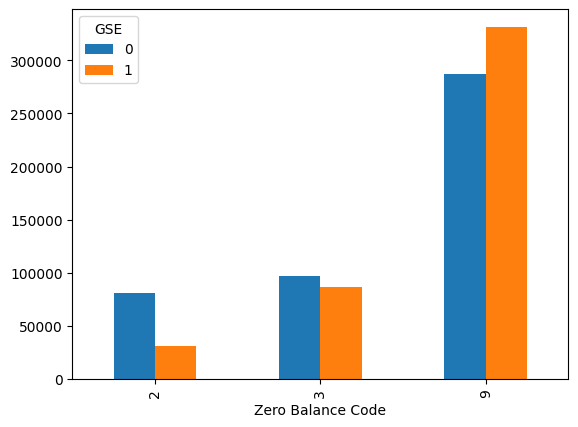

In [ ]:
grouped = df1.groupby(['Zero Balance Code', 'GSE']).size().unstack(fill_value=0)

# Plotting the bar graph
ax = grouped.plot(kind='bar')
plt.show()

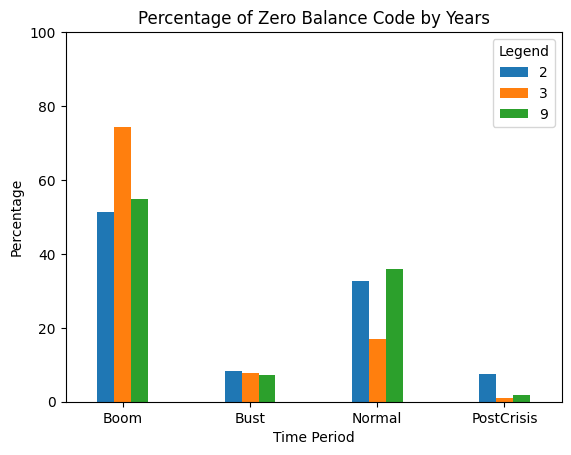

In [ ]:
grouped = df.groupby(['buckets','Zero Balance Code']).size().unstack(fill_value=0)

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100

# Plotting the bar graph
ax = grouped_percentage.plot(kind='bar', width=0.4)

# Customizing the plot
plt.xlabel('Time Period')
plt.ylabel('Percentage')
plt.title('Percentage of Zero Balance Code by Years')
plt.legend(title='Legend')
plt.ylim(0, 100)  # Setting y-axis limit to 0-100%

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped_percentage.index, rotation=0)

plt.show()

In [ ]:
pd.options.display.float_format = "{:,.4f}".format

In [ ]:
df1.groupby('GSE')[['REO','TPS','SS']].mean()*100

,REO,TPS,SS
GSE,,,
0,61.83,17.32,20.85
1,73.85,6.79,19.36


In [ ]:
df1.groupby('GSE')[['REO','TPS','SS']].sum()

,REO,TPS,SS
GSE,,,
0,287013,80399,96804
1,331566,30475,86915


In [ ]:
df1[['REO','TPS','SS']].sum()

REO    618579
TPS    110874
SS     183719
dtype: int64

In [ ]:
df1.groupby('orig_year')[['REO','TPS','SS']].mean()*100

,REO,TPS,SS
orig_year,,,
1999,71.29,23.24,5.47
2000,85.34,9.41,5.25
2001,83.56,9.83,6.61
2002,81.27,10.95,7.78
2003,75.15,13.66,11.19
2004,71.67,12.83,15.50
2005,63.73,12.23,24.04
2006,63.52,10.48,26.00
2007,64.14,9.85,26.01


In [ ]:
df1.groupby('buckets')[['REO','TPS','SS']].mean()*100

,REO,TPS,SS
buckets,,,
Boom,63.80,10.66,25.55
Bust,65.15,13.73,21.12
Normal,76.81,12.50,10.69
PostCrisis,53.18,38.18,8.64


<Axes: >

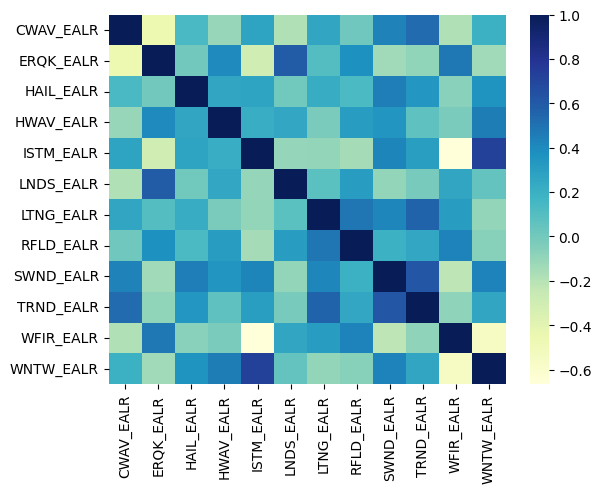

In [ ]:
sns.heatmap(df1[list(xx[7])].corr(),cmap="YlGnBu")

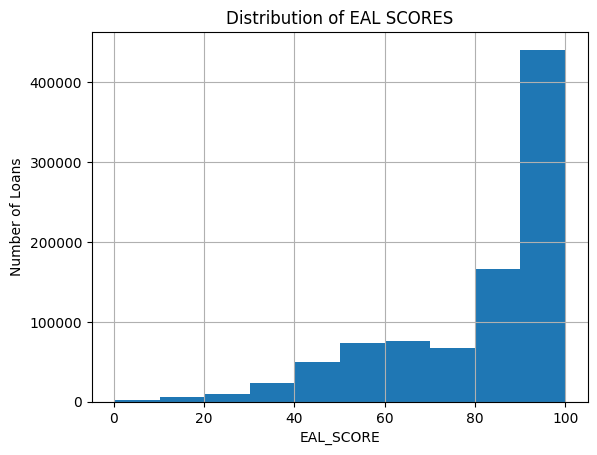

In [ ]:
ax = df1['EAL_SCORE'].hist()
plt.xlabel('EAL_SCORE')
plt.ylabel('Number of Loans')
plt.title('Distribution of EAL SCORES')
plt.show()

In [ ]:
df1.groupby('Zero Balance Code')['EAL_SCORE'].mean()

Zero Balance Code
2   83.63
3   88.27
9   78.41
Name: EAL_SCORE, dtype: float64

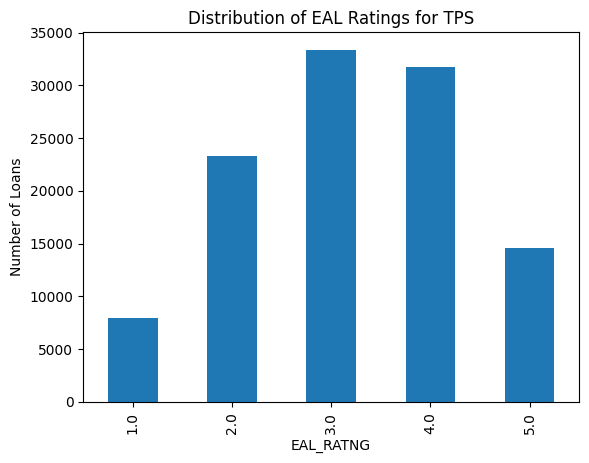

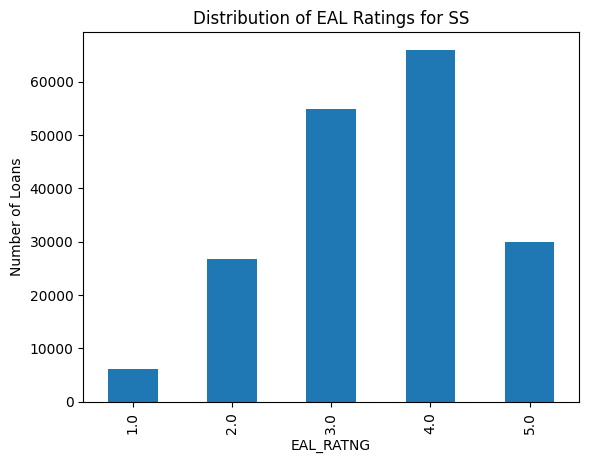

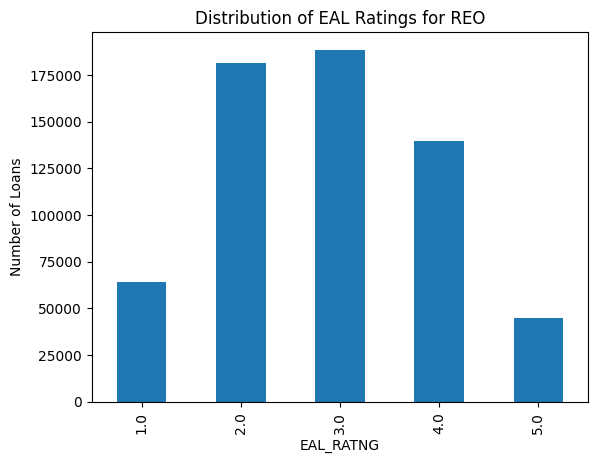

In [ ]:
j= {3:'SS',2:'TPS',9:'REO'}
for i in [2,3,9]:
  df1.groupby(['Zero Balance Code','EAL_RATNG'])['Loss Rate'].count()[i].plot(kind='bar')
  plt.xlabel('EAL_RATNG')
  plt.ylabel('Number of Loans')
  plt.title(f'Distribution of EAL Ratings for {j[i]}')
  plt.show()

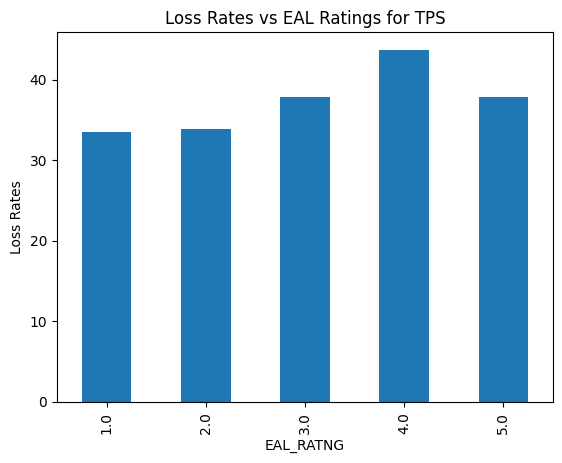

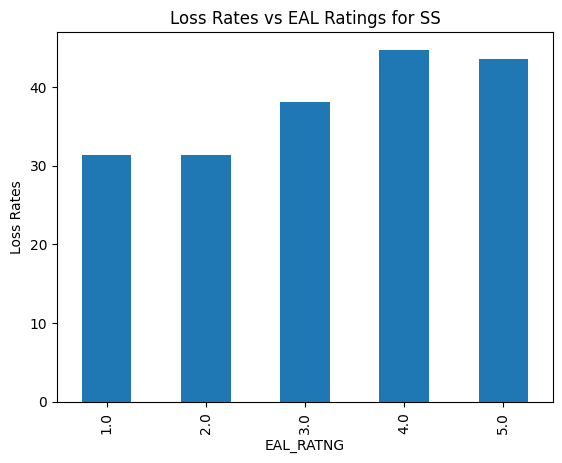

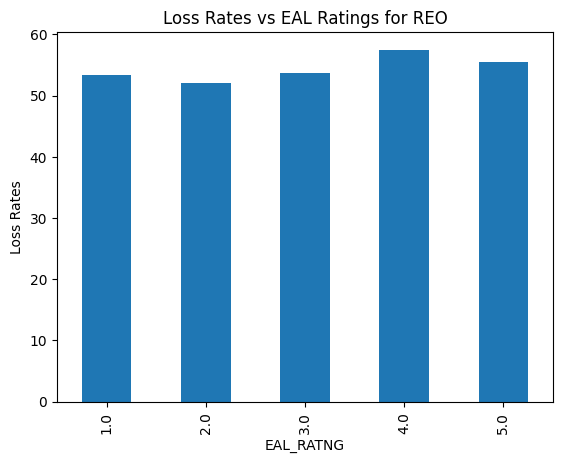

In [ ]:
for i in [2,3,9]:
  df1.groupby(['Zero Balance Code','EAL_RATNG'])['Loss Rate'].mean()[i].plot(kind='bar')
  plt.xlabel('EAL_RATNG')
  plt.ylabel('Loss Rates')
  plt.title(f'Loss Rates vs EAL Ratings for {j[i]}')
  plt.show()

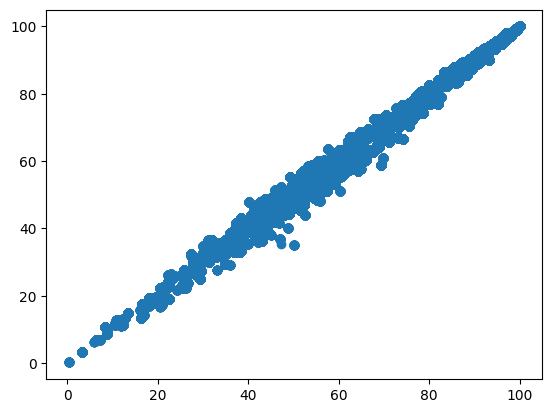

In [ ]:
plt.scatter(df1['RISK_SCORE','EAL_SCORE']])
plt.show()

{'whiskers': [<matplotlib.lines.Line2D at 0x7b2d9a59b5b0>,
 'caps': [<matplotlib.lines.Line2D at 0x7b2d9a598610>,
 'boxes': [<matplotlib.lines.Line2D at 0x7b2d9a598280>],
 'medians': [<matplotlib.lines.Line2D at 0x7b2d9a599960>],
 'fliers': [<matplotlib.lines.Line2D at 0x7b2d9a599990>],
 'means': []}

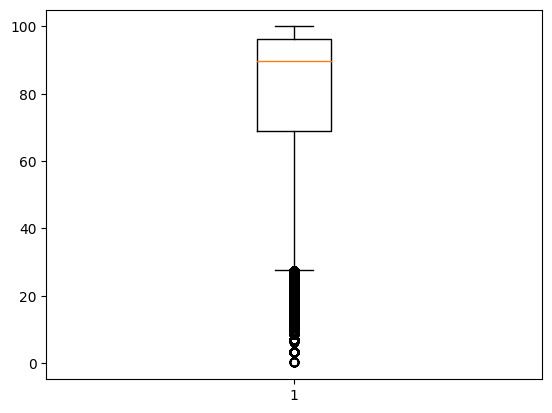

In [ ]:
plt.boxplot(df1['EAL_SCORE'])

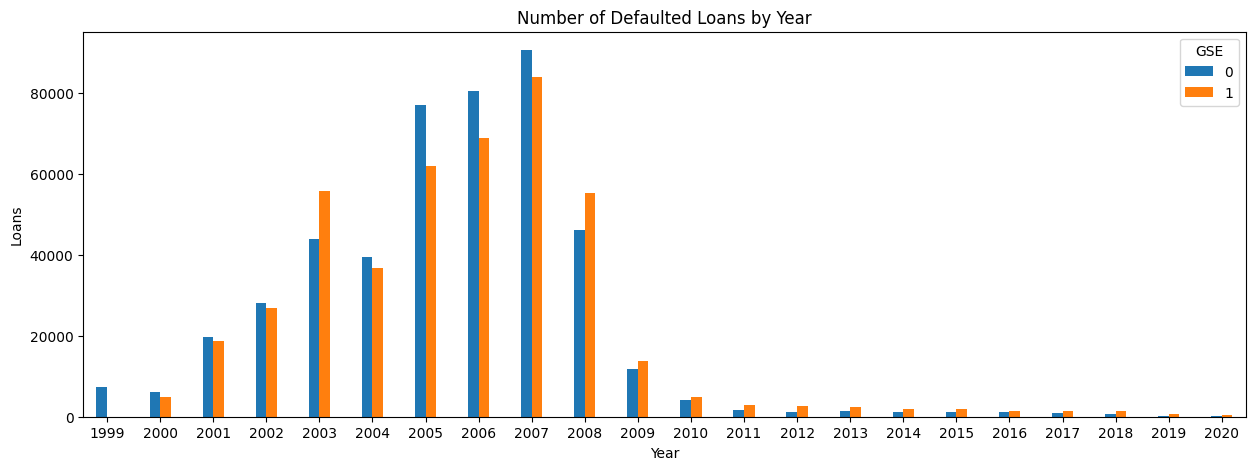

In [ ]:
grouped = df1.groupby(['orig_year','GSE']).size().unstack(fill_value=0)

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100
# Plotting the bar graph
ax = grouped.plot(kind='bar', width=0.4,figsize=(15, 5))
# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Loans')
plt.title('Number of Defaulted Loans by Year')
plt.legend(title='GSE')

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped.index, rotation=0)

# Adding percentage labels to the bars
#for container in ax.containers:
#    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.show()

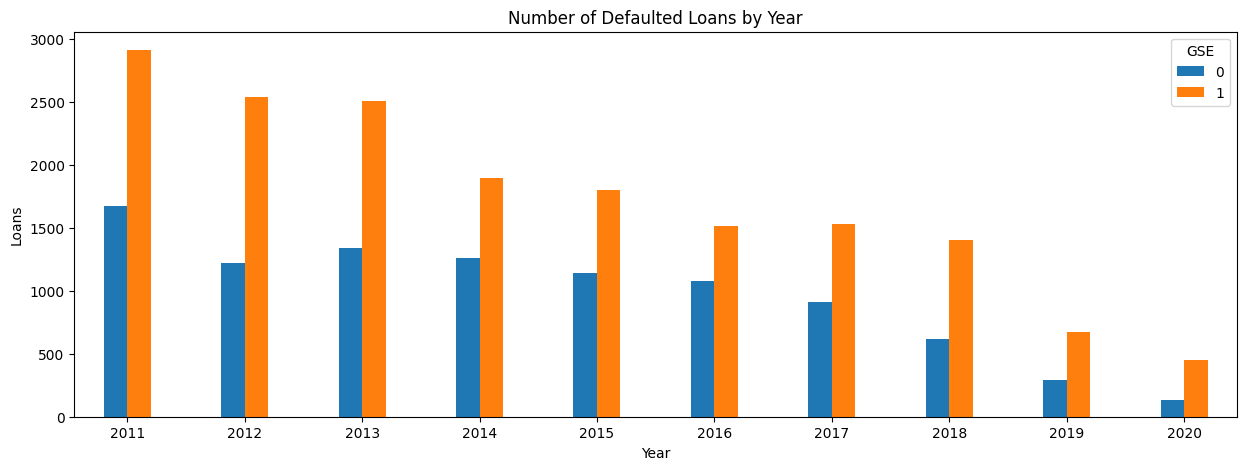

In [ ]:
grouped = df1.groupby(['orig_year','GSE']).size().unstack(fill_value=0).loc[2011:,:]

# Calculating the total count of each GSE value across all Zero Balance Codes
total_counts = grouped.sum(axis=0)

# Calculating the percentage for each GSE value based on the total count of each GSE value
grouped_percentage = grouped.div(total_counts, axis=1) * 100
# Plotting the bar graph
ax = grouped.plot(kind='bar', width=0.4,figsize=(15, 5))
# Customizing the plot
plt.xlabel('Year')
plt.ylabel('Loans')
plt.title('Number of Defaulted Loans by Year')
plt.legend(title='GSE')

# Adjusting x-axis tick labels
ax.set_xticklabels(grouped.index, rotation=0)

# Adding percentage labels to the bars
#for container in ax.containers:
#    ax.bar_label(container, fmt='%.1f%%', label_type='edge')

plt.show()

In [ ]:
df1.groupby('orig_year')['Loss Rate'].mean()

orig_year
1999   37.43
2000   45.81
2001   49.51
2002   51.68
2003   46.07
2004   48.81
2005   49.83
2006   53.68
2007   52.11
2008   48.30
2009   40.51
2010   41.30
2011   41.02
2012   36.00
2013   33.18
2014   32.59
2015   31.51
2016   29.50
2017   35.33
2018   41.95
2019   47.28
2020   52.57
Name: Loss Rate, dtype: float64

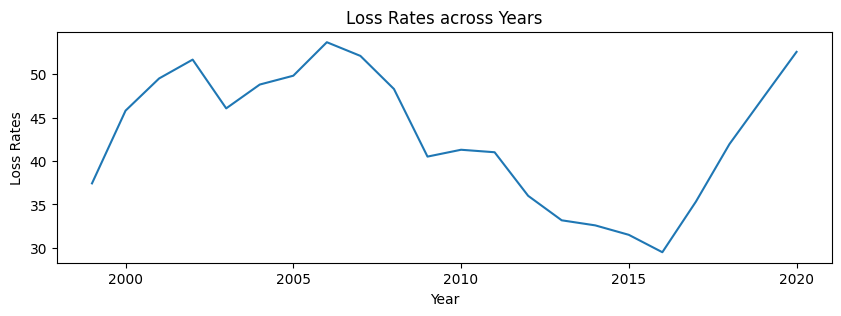

In [ ]:
df1.groupby('orig_year')['Loss Rate'].mean().plot(figsize=(10, 3))
plt.xlabel('Year')
plt.ylabel('Loss Rates')
plt.title(f'Loss Rates across Years')
plt.show()

# TRAIN TEST

In [ ]:
def Runnestedlogitv(varlist,varlist2,df):
  df2 = df[varlist]
  df2 = df2.dropna()
  TPS = df2.pop('TPS')
  REO = df2.pop('REO')
  SS  = df2.pop('SS')

  df3  = df[varlist2]
  df3  = df3.dropna()
  TPS  = df3.pop('TPS')
  REO  = df3.pop('REO')
  SS2  = df3.pop('SS')
  REO2 = REO[SS==0]
  TPS2 = TPS[SS==0]
  df3  = df3[SS==0]

  SSlogit = modelvalid(SS,df2)
  #print(TPSlogit.summary())
  SSlogit_pred = SSlogit.predict(sm.add_constant(df2))


  TPS2logit = modelvalid(TPS2,df3)
  #print(REO2logit.summary())
  TPS2logit_pred = TPS2logit.predict(sm.add_constant(df3))

  return SSlogit,TPS2logit,SS,TPS2,SSlogit_pred,TPS2logit_pred

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
def modelvalid(exog,df):
  X_train, X_test, y_train, y_test = train_test_split(df, exog, test_size=0.2, random_state=758)
  model = sm.Logit(y_train, sm.add_constant(X_train)).fit()
  pr1 = model.predict(sm.add_constant(X_train))
  pr2 = model.predict(sm.add_constant(X_test))
  printres((model,model,y_train,y_test,pr1,pr2))
  return model

In [ ]:
validation = Runnestedlogitv(v3,v3,df1)

Optimization terminated successfully.
         Current function value: 0.423107
         Iterations 7
The area under curve is 77.40%
The area under curve is 77.65%
KS between class1 and others: 0.4211 (p-value: 0.000e+00)
KS between class1 and others: 0.4263 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.359865
         Iterations 7
The area under curve is 77.31%
The area under curve is 77.48%
KS between class1 and others: 0.4090 (p-value: 0.000e+00)
KS between class1 and others: 0.4126 (p-value: 0.000e+00)


In [ ]:
validation2 = Runnestedlogitv(v3+list(xx[9]),v3+list(xx[9]),df1)

Optimization terminated successfully.
         Current function value: 0.410056
         Iterations 7
The area under curve is 79.11%
The area under curve is 79.23%
KS between class1 and others: 0.4516 (p-value: 0.000e+00)
KS between class1 and others: 0.4530 (p-value: 0.000e+00)
Optimization terminated successfully.
         Current function value: 0.339578
         Iterations 7
The area under curve is 81.11%
The area under curve is 81.31%
KS between class1 and others: 0.4689 (p-value: 0.000e+00)
KS between class1 and others: 0.4713 (p-value: 0.000e+00)


In [ ]:
printres(Runnestedlogit(v3,v3,df1))

Optimization terminated successfully.
         Current function value: 0.400347
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355055
         Iterations 7
The area under curve is 80.32%
The area under curve is 78.27%
KS between class1 and others: 0.4717 (p-value: 0.000e+00)
KS between class1 and others: 0.4264 (p-value: 0.000e+00)


In [ ]:
Disaster = Runnestedlogit(v3+['disaster_6m'],v3+['disaster_6m'],df1)
printres(Disaster)

Optimization terminated successfully.
         Current function value: 0.400330
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.355010
         Iterations 7
The area under curve is 80.33%
The area under curve is 78.28%
KS between class1 and others: 0.4717 (p-value: 0.000e+00)
KS between class1 and others: 0.4264 (p-value: 0.000e+00)


In [ ]:
df1['disaster_6m'] = df1.past_6m_incidents.apply(lambda x: 1 if x >= 1 else 0)
df1['disaster_3m'] = df1.past_3m_incidents.apply(lambda x: 1 if x >= 1 else 0)

In [ ]:
print(Disaster[0].summary())
print(Disaster[1].summary())

                           Logit Regression Results                           
Dep. Variable:                     SS   No. Observations:               913172
Model:                          Logit   Df Residuals:                   913142
Method:                           MLE   Df Model:                           29
Date:                Thu, 09 May 2024   Pseudo R-squ.:                  0.2026
Time:                        22:38:12   Log-Likelihood:            -3.6557e+05
converged:                       True   LL-Null:                   -4.5845e+05
Covariance Type:            nonrobust   LLR p-value:                     0.000
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
const                   -15.9756      0.227    -70.517      0.000     -16.420     -15.532
cltv_current1             0.0191      0.001     31.334      0.000       0.018       0.020
cltv_cur

In [ ]:
Disaster[1].params

const                   -6.969940
cltv_current1           -0.052257
cltv_current2            0.002244
cltv_current3            0.017151
fico1                    0.000467
fico2                    0.001328
fico3                    0.000431
hpat2y                   2.127648
dur_def_episode         -0.031264
judicial                 0.054682
deficiency               0.383424
flag_24                  0.109815
noowner_occ             -0.033406
proptype_CP             -0.597391
proptype_MH             -0.767950
proptype_PU              0.019530
proptype_SF             -0.297115
GSE                     -1.690100
Boom                     0.343869
Bust                     0.538118
PostCrisis               1.565159
channel_C                0.148684
channel_R                0.190308
loanpurpose_N            0.037124
loanpurpose_P            0.078752
loanpurpose_C            0.162376
Current Interest Rate   -0.184152
loan_age                 0.012327
Log Original UPB         0.612649
disaster_6m   

In [ ]:
Disaster[0].params

const                   -15.975623
cltv_current1             0.019090
cltv_current2             0.024718
cltv_current3             0.003025
fico1                    -0.002237
fico2                     0.002745
fico3                     0.003135
hpat2y                    0.969523
dur_def_episode          -0.083360
judicial                  1.044044
deficiency               -0.163811
flag_24                   0.350779
noowner_occ               0.141074
proptype_CP              -0.315830
proptype_MH              -0.743730
proptype_PU              -0.270249
proptype_SF              -0.399909
GSE                      -0.554987
Boom                      0.167216
Bust                      0.242407
PostCrisis               -0.447648
channel_C                -0.022993
channel_R                -0.058807
loanpurpose_N            -0.046613
loanpurpose_P            -0.109749
loanpurpose_C             0.081503
Current Interest Rate    -0.098047
loan_age                  0.005276
Log Original UPB    

In [ ]:
df1[['proptype_CP','proptype_MH','proptype_PU','proptype_SF']].sum().sum()

832626

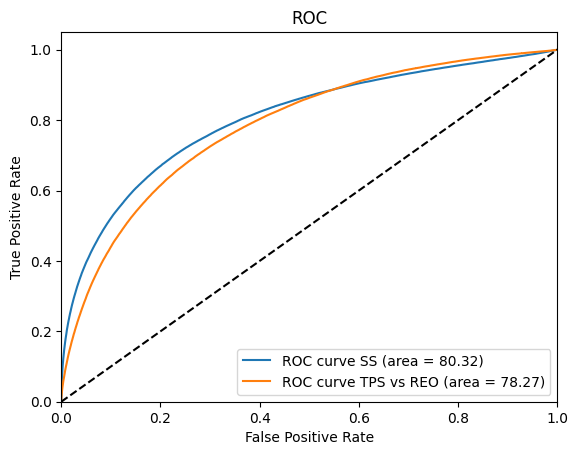

In [ ]:
fpr1, tpr1, _ = roc_curve(Base[2], Base[4])
roc_auc1 = auc(fpr1, tpr1)*100

fpr2, tpr2, _ = roc_curve(Base[3], Base[5])
roc_auc2 = auc(fpr2, tpr2)*100


plt.figure()
plt.plot(fpr1, tpr1, label=f'ROC curve SS (area = {roc_auc1:0.2f})')
plt.plot(fpr2, tpr2, label=f'ROC curve TPS vs REO (area = {roc_auc2:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

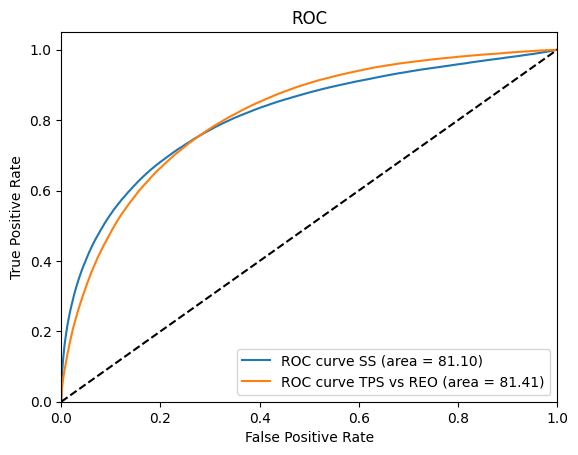

In [ ]:
fpr1, tpr1, _ = roc_curve(NRI[2], NRI[4])
roc_auc1 = auc(fpr1, tpr1)*100

fpr2, tpr2, _ = roc_curve(NRI[3], NRI[5])
roc_auc2 = auc(fpr2, tpr2)*100


plt.figure()
plt.plot(fpr1, tpr1, label=f'ROC curve SS (area = {roc_auc1:0.2f})')
plt.plot(fpr2, tpr2, label=f'ROC curve TPS vs REO (area = {roc_auc2:0.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

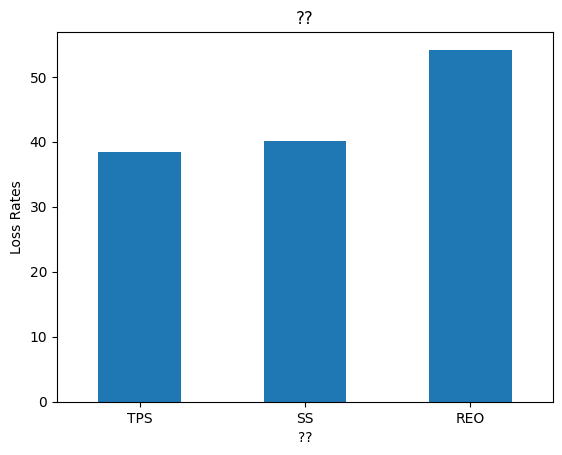

In [ ]:
ax = df1.groupby('Zero Balance Code')['Loss Rate'].mean().plot(kind='bar')
ax.set_xticklabels(['TPS','SS','REO'], rotation=0)

plt.xlabel('??')
plt.ylabel('Loss Rates')
plt.title('??')
plt.show()

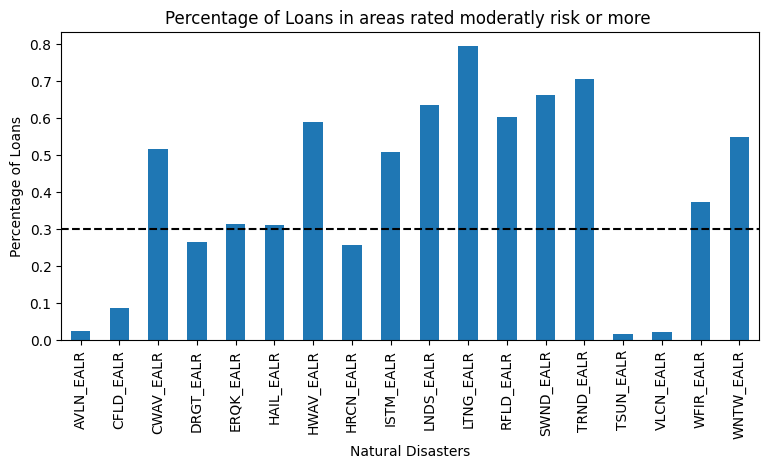

In [ ]:
ax = (df.filter(regex='EALR')>=3).mean().plot(kind='bar',figsize=(9, 4))
plt.axhline(y=0.3, color='black', linestyle='--')
plt.xlabel('Natural Disasters')
plt.ylabel('Percentage of Loans')
plt.title('Percentage of Loans in areas rated moderatly risk or more ')
plt.show()

In [ ]:
from sklearn.metrics import classification_report


In [ ]:
k = classification_report(NRI[2],round(NRI[4]))

In [ ]:
print(k)

              precision    recall  f1-score   support

           0       0.85      0.97      0.91    729453
           1       0.72      0.34      0.46    183719

    accuracy                           0.84    913172
   macro avg       0.79      0.65      0.68    913172
weighted avg       0.83      0.84      0.82    913172



In [ ]:
print(classification_report(NRI[3],round(NRI[5])))

              precision    recall  f1-score   support

           0       0.87      0.98      0.92    618579
           1       0.61      0.21      0.31    110874

    accuracy                           0.86    729453
   macro avg       0.74      0.59      0.62    729453
weighted avg       0.83      0.86      0.83    729453

